In [535]:
import pandas as pd
import numpy as np
import pyperclip as pc
import requests
import kaggle

# ___________________________________________________________________
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection as ms
from sklearn import datasets, svm, metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
import sklearn.datasets as datasets
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# ____________________________________________________________________
from scipy import stats
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import chart_studio.plotly as py
import cufflinks as cf
import datetime as dt

#_____________________________________________________________________
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

from joblib import Parallel, delayed
import multiprocessing
from IPython.display import display, clear_output
import plotly.tools as tls
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import json

#___________________________________________________________________
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)
cf.go_offline()

# tls.set_credentials_file(username='marcelofprado', api_key='cftsFWfYZ7DgpGQtDuRe')
# init_notebook_mode(connected=True)

np.seterr(divide='ignore')

{'divide': 'ignore', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [536]:
resp = pd.read_csv('resp.csv')
resp.columns = ['state', 'equipments']
resp_sum = resp['equipments'].sum()
resp = resp.set_index('state', drop = True)

In [537]:
str_today = (dt.date.today() - dt.timedelta(hours=24)).strftime('%Y-%m-%d')
str_cases = (dt.date.today() - dt.timedelta(days=13)).strftime('%Y-%m-%d')
url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-' + str_today + '.xlsx'
# file = requests.get(url)
world_data = pd.read_excel(url)
world_data.columns = ['date', 'day', 'month', 'year', 'cases', 'deaths', 'country', 'country_geoid', 'country_code', 'population']
print(str_cases + " - " + str_today)
world_data.head(5)

2020-03-16 - 2020-03-28


,date,day,month,year,cases,deaths,country,country_geoid,country_code,population
0,2020-03-28,28,3,2020,16,1,Afghanistan,AF,AFG,37172386.0
1,2020-03-27,27,3,2020,0,0,Afghanistan,AF,AFG,37172386.0
2,2020-03-26,26,3,2020,33,0,Afghanistan,AF,AFG,37172386.0
3,2020-03-25,25,3,2020,2,0,Afghanistan,AF,AFG,37172386.0
4,2020-03-24,24,3,2020,6,1,Afghanistan,AF,AFG,37172386.0


In [538]:
pt_world_data = world_data.pivot_table(values = 'cases', index = 'country', columns = 'date', aggfunc = sum)
pt_world_data = pt_world_data.cumsum(axis = 1)
pt_world_data = pt_world_data[pt_world_data['2020-03-26'] > 1000].sort_values(by='2020-03-26', ascending = False)

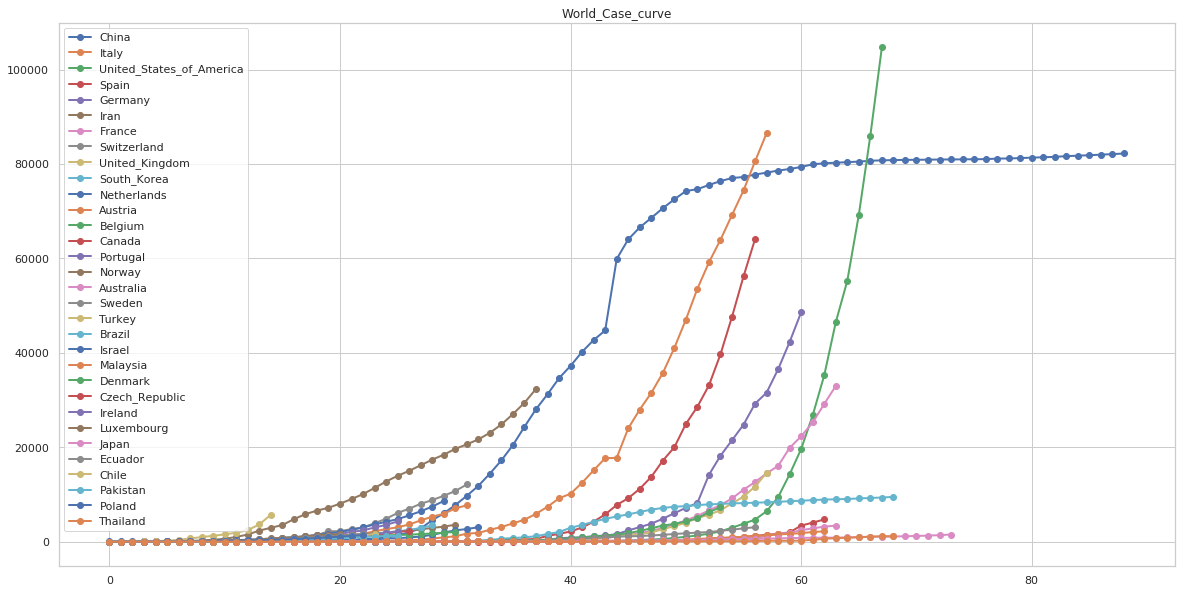

In [539]:
df = pd.DataFrame()
for i in pt_world_data.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
plt.figure(figsize = (20,10))
font = {'family' : 'normal',
        'weight' : 'regular',
        'size'   : 12}

plt.rc('font', **font)
title = 'World_Case_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

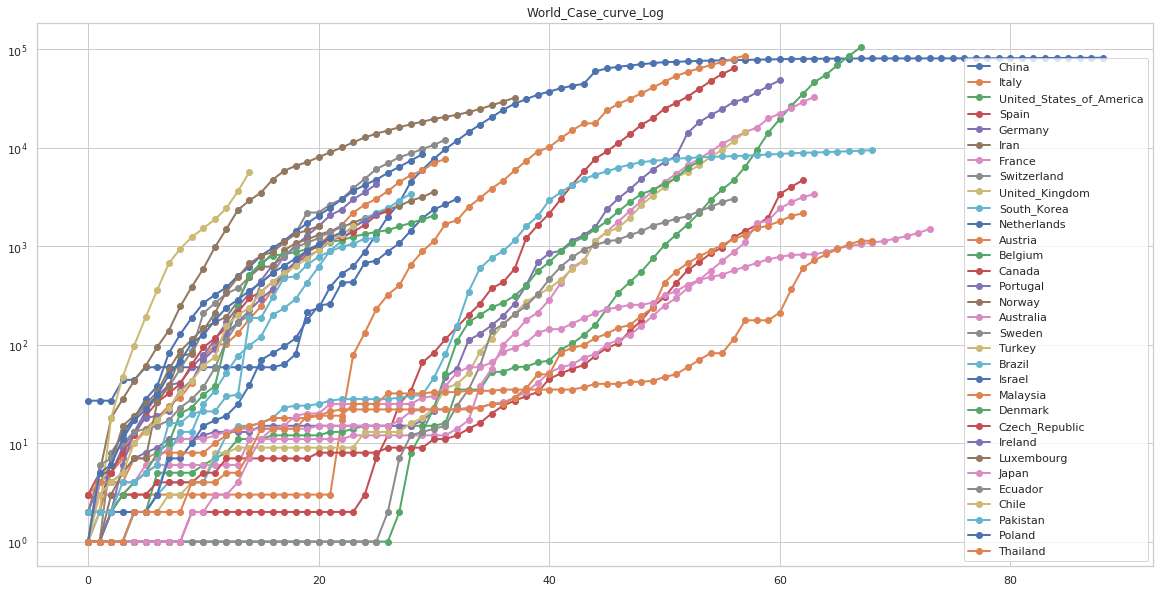

In [540]:
df = pd.DataFrame()
for i in pt_world_data.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
plt.yscale('log')
title = 'World_Case_curve_Log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

s:  0.8446004309005914
s_star:  2.3270478123838654


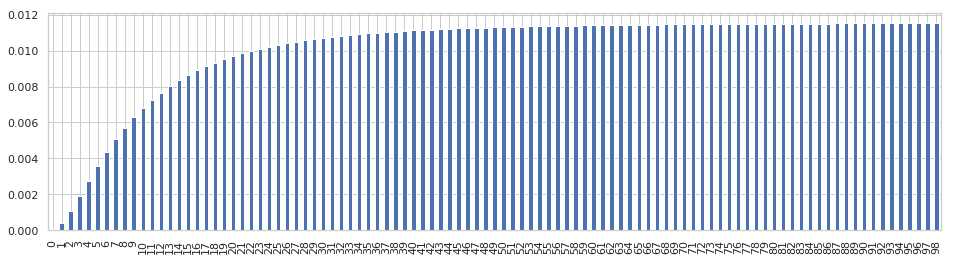

In [541]:
zmeanHDT = 13
zsdHDT = 12.7
zmedianHDT = 9.1
muHDT = np.log(zmedianHDT)
sigmaHDT = np.sqrt(2*(np.log(zmeanHDT/zmedianHDT)))
s = sigmaHDT
cCFRBaseline = 1.38
cCFREstimateRange = [1.23, 1.53]
#cCFRIQRRange <- c(1.3, 1.4)

print('s: ',sigmaHDT)
print('s_star: ',np.exp(sigmaHDT))
# print('mu: ', muHDT)

# Hospitalisation to death distribution
def HDT(x):
    dist = stats.lognorm(s = sigmaHDT, scale = zmedianHDT)
    a = dist.cdf(x)
    return a
    

x = list(range(1,100))
p_curve = pd.Series([HDT(i) for i in x])
p_curve = p_curve / p_curve.sum()

plt.figure(figsize=(16,4))
p_curve.plot(kind='bar')


In [594]:
world_data['rel_date'] = (dt.datetime.now() - pd.to_datetime(world_data['date'])).dt.days - 1
world_data['known'] = HDT(world_data['rel_date'])
world_data['known_cases'] = world_data['known'] * world_data['cases']

In [620]:
wd_known_cases = world_data.pivot_table(values = 'known_cases', index = 'country', columns = 'date', aggfunc = 'sum').fillna(0).cumsum(axis = 1)
wd_deaths = world_data.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc = 'sum').cumsum(axis = 1).fillna(0)
wd_death_rate = (wd_deaths / wd_known_cases * 100).fillna(0)
wd_death_rate = wd_death_rate[wd_death_rate[str_today] > 0]
wd_reported = (3.2 / wd_death_rate * 100).replace(np.inf, np.nan)
wd_reported = wd_reported[wd_reported.columns[-4:]].sort_values(by = str_today, ascending = False)
wd_reported.loc[['Germany', 'United_States_of_America']]

date,2020-03-25,2020-03-26,2020-03-27,2020-03-28
country,,,,
Germany,262.398635,200.377129,157.143443,122.330126
United_States_of_America,66.864333,52.557522,42.766585,32.469534


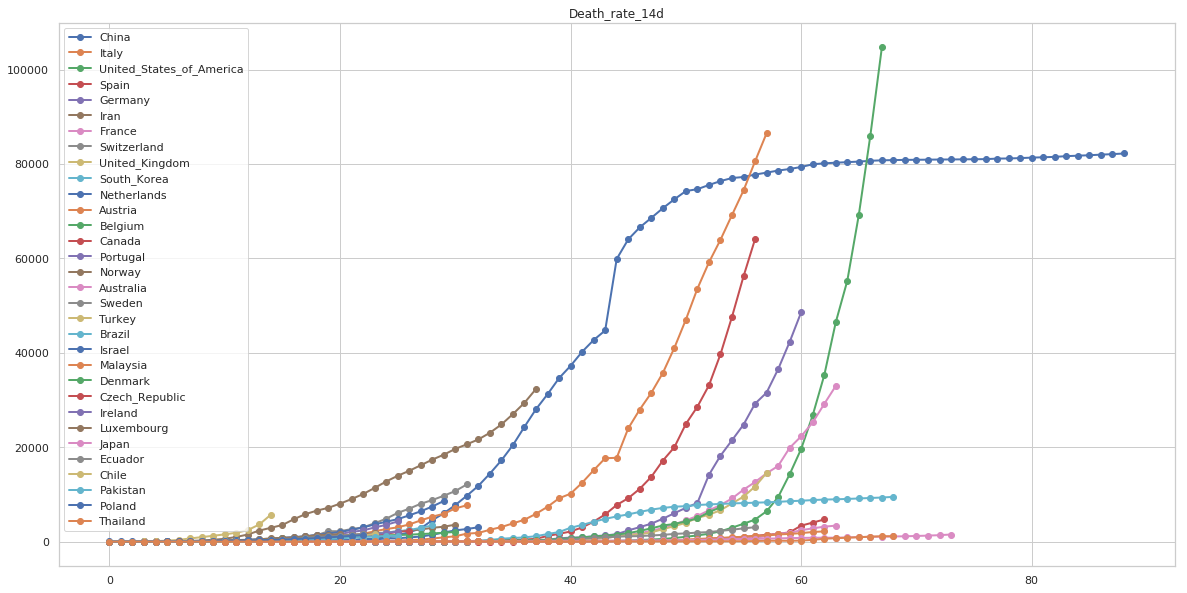

In [542]:
    
# temp = world_data[['cases','country']]
# temp.columns = ['cases_14d', 'country']
# temp['date'] = world_data['date'] + dt.timedelta(days=13)
# temp = temp[temp['date'] <= str_today]
# world_data_adj = world_data.merge(temp, on = ['country', 'date'])

# world_data_adj['death_rate_14d'] = world_data_adj['deaths'] / world_data_adj['cases_14d']
# world_data_adj = world_data_adj[world_data_adj['date'] > '2020-03-22']

# pt_world_cases = world_data_adj.pivot_table(values = 'cases_14d', index = 'country', columns = 'date', aggfunc='mean')
# pt_world_cases = pt_world_cases.cumsum(axis = 1)
# pt_world_cases = pt_world_cases[pt_world_cases['2020-03-26'] > 100].sort_values(by='2020-03-26', ascending = False)

# pt_world_deaths = world_data_adj.pivot_table(values = 'deaths', index = 'country', columns = 'date', aggfunc='mean')
# pt_world_deaths = pt_world_deaths.cumsum(axis = 1)
# pt_world_deaths = pt_world_deaths[pt_world_deaths['2020-03-26'] > 0].sort_values(by='2020-03-26', ascending = False)

# df = pt_world_deaths / pt_world_cases * 100
# df = df.sort_values(by='2020-03-26', ascending = False).dropna()


plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Death_rate_14d'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

In [543]:
us_daily_url = 'https://covidtracking.com/api/us/daily.csv'
us_covid = pd.read_csv(us_daily_url)
us_covid['date'] = pd.to_datetime(us_covid['date'], format='%Y%m%d')
us_covid = us_covid.set_index('date', drop = True)
us_covid = us_covid.sort_values(by = 'date', ascending = True)
us_covid['new_cases'] = us_covid['positive'].diff().fillna(0)
us_data = us_covid.copy()

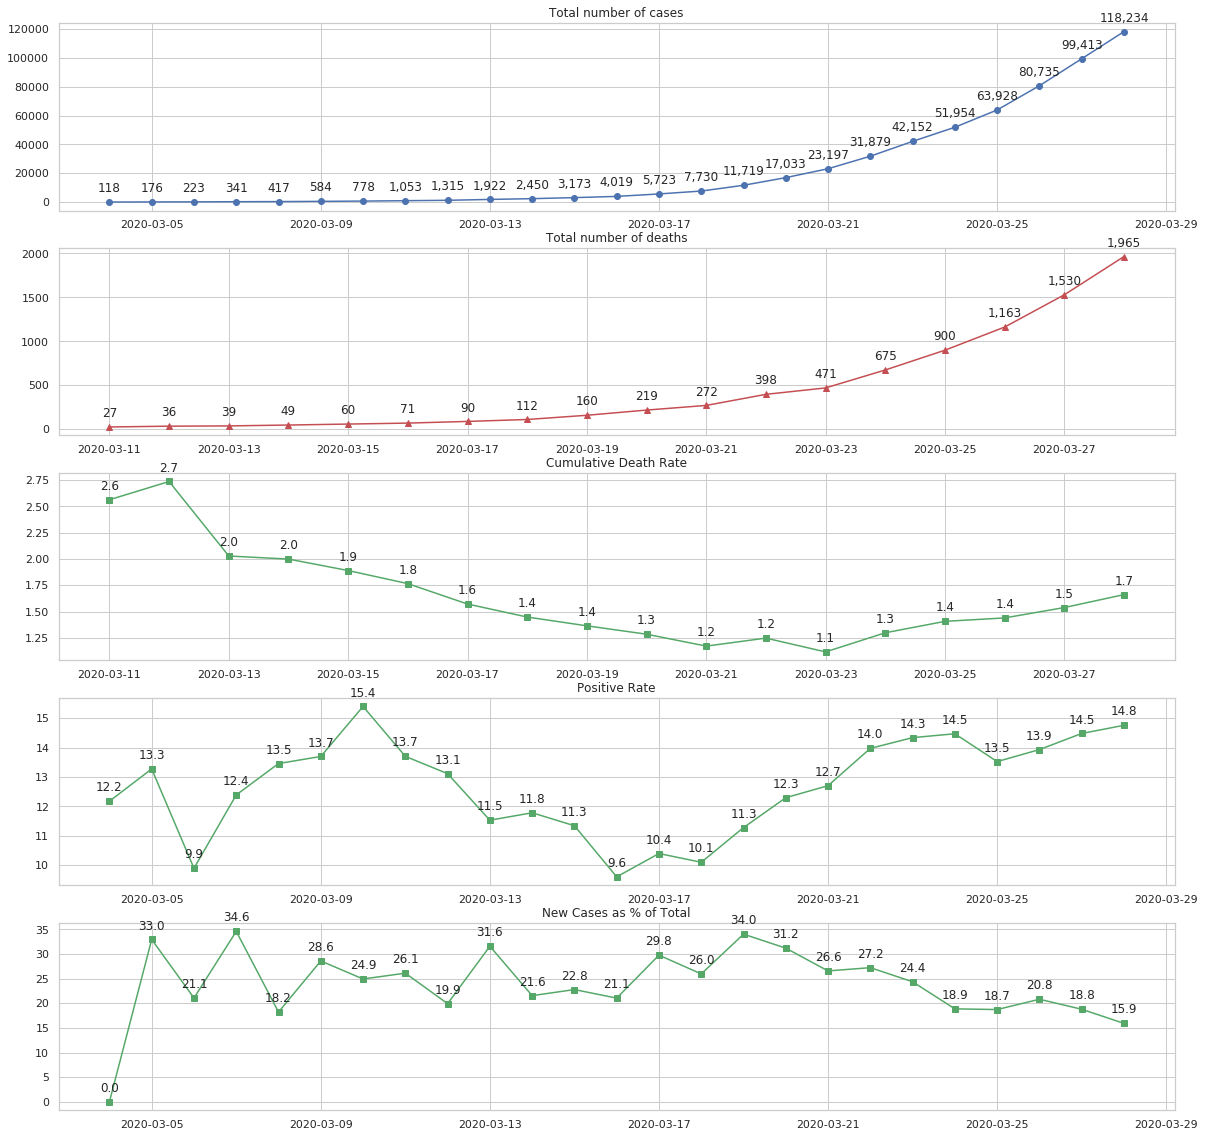

In [544]:
plt.figure(figsize = (20,20))

# plt.gca().title('Italian Cases')

plt.subplot('511')
xs = us_data.index.values
ys = us_data['positive']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = us_data['death']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = us_data['death'] / us_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('Positive Rate')
ys = us_data['positive'] / us_data['total'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = us_data['new_cases'] / us_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('./img/us_overview')
plt.show()

In [545]:
states_daily_url = 'http://covidtracking.com/api/states/daily.csv'
us_covid_state = pd.read_csv(states_daily_url)
us_covid_state['date'] = pd.to_datetime(us_covid_state['date'], format='%Y%m%d')
us_covid_state = us_covid_state.set_index('date', drop = True)
ny_covid = us_covid_state[us_covid_state['state'] == 'NY']
ny_covid = ny_covid.sort_values(by='date')
ny_covid['new_cases'] = ny_covid['positive'].diff().fillna(0)
ny_data = ny_covid.copy()
# ny_data

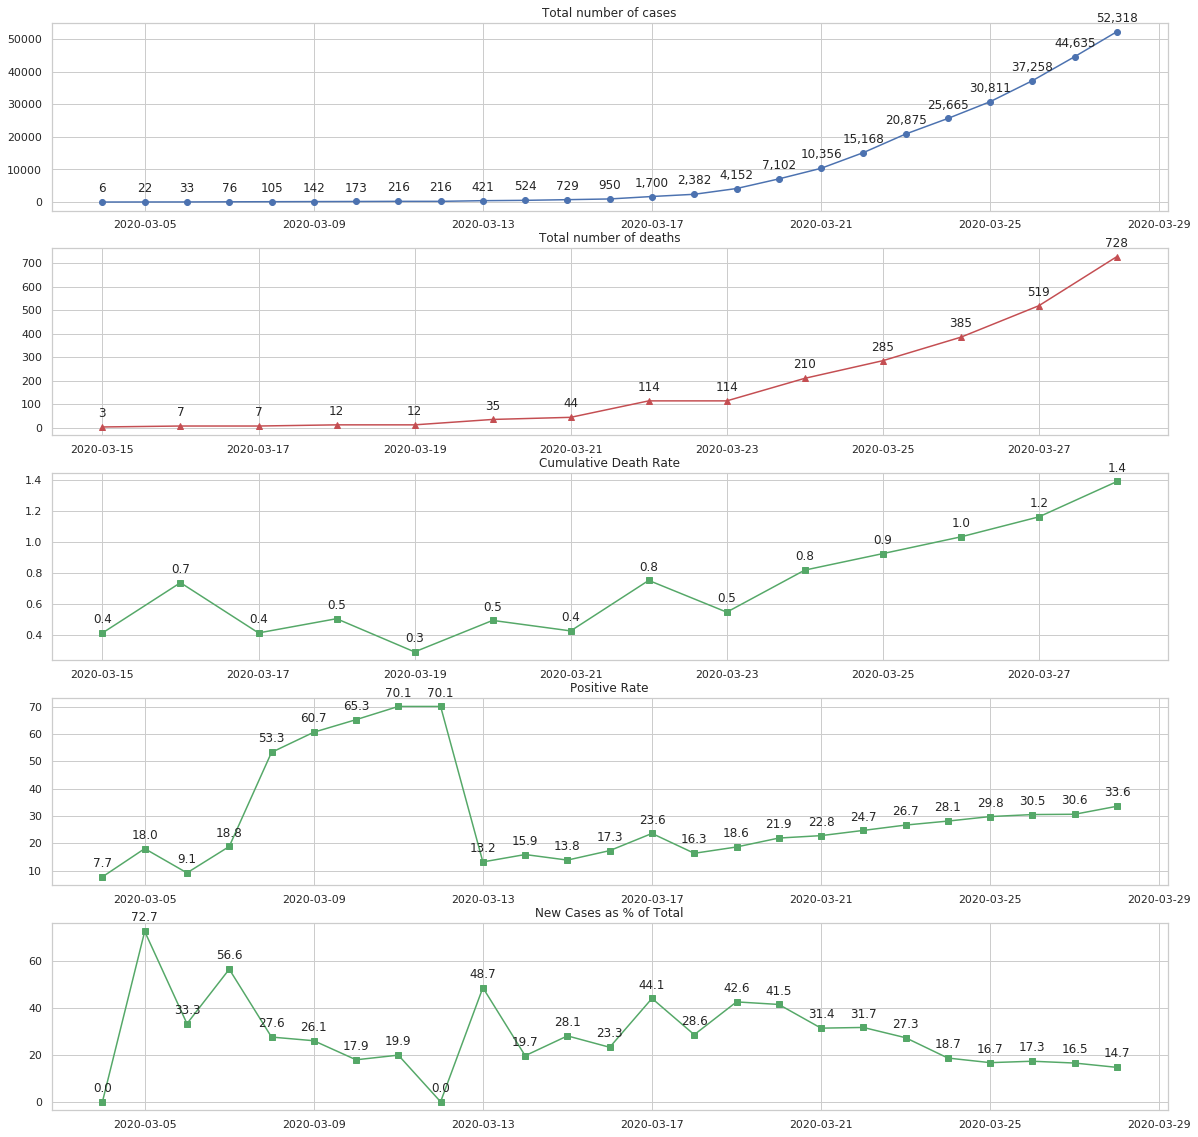

In [546]:
plt.figure(figsize = (20,20))

# plt.gca().title('Italian Cases')

plt.subplot('511')
xs = ny_data.index.values
ys = ny_data['positive']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = ny_data['death']
plt.plot(xs, ys, 'r^-')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = ny_data['death'] / ny_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('Positive Rate')
ys = ny_data['positive'] / ny_data['total'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('515')
plt.gca().set_title('New Cases as % of Total')
ys = ny_data['new_cases'] / ny_data['positive'] * 100
plt.plot(xs, ys, 'gs-')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig('./img/ny_overview')
plt.show()

In [547]:
us_state = us_covid_state[us_covid_state.index == str_today].set_index('state', drop = True)
us_state['positive_rate'] = us_state['positive'] / us_state['total'] * 100
us_state['death_rate'] = us_state['death'] / us_state['positive'] * 100
us_state = us_state.fillna(0)

us_state_data = pd.read_csv('us_states_data.csv')
us_state_data.columns = ['state', 'population','area-miles', 'area']
us_state_data['population'] = us_state_data['population'].str.replace(',','').astype(int)
us_state_data['area-miles'] = us_state_data['area-miles'].str.replace(',','').astype(int)
us_state_data['area'] = us_state_data['area'].str.replace(',','').astype(int)
us_state_data['density'] = us_state_data['population'].astype(float) / us_state_data['area'].astype(float)
us_state_data = us_state_data.set_index('state', drop = True)

us_state = us_state.merge(us_state_data, on='state')
us_state['tests_per_1000'] = us_state['total'] / us_state['population'] * 1000
us_state['positive_per_1000'] = us_state['positive'] / us_state['population'] * 1000

In [548]:
# us_state.sort_values(by='positive_rate', ascending=False)
df_corr = us_state[['tests_per_1000','positive_per_1000','positive_rate','death_rate','density']].sort_values(by='tests_per_1000', ascending=False).corr()

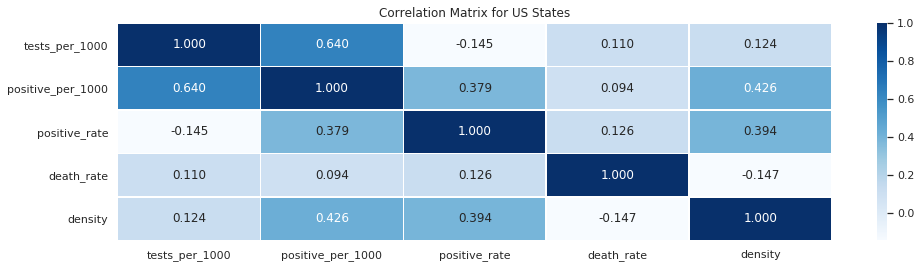

In [549]:
plt.figure(figsize = (16,4))
title = 'Correlation Matrix for US States'
# df_result = df_count.div(df_count.sum(axis = 0).sum(), axis = 1) * 100
plt.title(title)
sns.heatmap(df_corr, annot = True, linewidths = 0.5, cmap='Blues', fmt=',.3f')
plt.savefig('./img/' + title)

In [550]:
br_state_file = './'
kaggle.api.authenticate()
kaggle.api.dataset_download_files('unanimad/corona-virus-brazil/metadata', path=br_state_file, unzip=True)

br_state = pd.read_csv('brazil_covid19.csv')
br_state['total'] = br_state['cases'] + br_state['refuses']
br_state['total_susp'] = br_state['cases'] +  br_state['refuses'] + br_state['suspects']
br_state['positive_rate'] = br_state['cases'] / br_state['total'] * 100
br_state_copy = br_state.copy()
br_state = br_state[br_state['date'] == str_today]
br_state = br_state.set_index('state', drop=True)
br_state['death_rate'] = br_state['deaths'] / br_state['cases'] * 100
br_state_data = pd.read_csv('br_states_data.csv')
br_state_data = br_state_data.drop(['Bandeira', 'Sede de governo','Alfabetização (2016)', 'Mortalidade infantil (2016)', 'Expectativa de vida (2016)'], axis = 1)
br_state_data.columns = ['state', 'state_2digits', 'area', 'population', 'density', 'gdp', 'share','gdp_per_capita', 'hdi']
br_state_data = br_state_data.set_index('state', drop=True)
br_state_data = br_state.merge(br_state_data, on='state')
br_state_data['area'] = br_state_data['area'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['population'] = br_state_data['population'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['gdp'] = br_state_data['gdp'].str.replace(',','').str.replace('\xa0','').astype(float)
br_state_data['gdp_per_capita'] = br_state_data['gdp_per_capita'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['hdi'] = br_state_data['hdi'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['density'] = br_state_data['density'].str.replace(',','.').str.replace('\xa0','').astype(float)
br_state_data['tests_per_1000'] = br_state_data['total'] / br_state_data['population'] * 1000
# br_state_data = br_state_data.set_index('state_2digits', drop = True)
br_state

,date,hour,suspects,refuses,cases,deaths,total,total_susp,positive_rate,death_rate
state,,,,,,,,,,
Acre,2020-03-28,NaN,0,0,25,0,25,25,100.0,0.000000
Alagoas,2020-03-28,NaN,0,0,14,0,14,14,100.0,0.000000
Amapá,2020-03-28,NaN,0,0,4,0,4,4,100.0,0.000000
Amazonas,2020-03-28,NaN,0,0,111,1,111,111,100.0,0.900901
Bahia,2020-03-28,NaN,0,0,128,0,128,128,100.0,0.000000
Ceará,2020-03-28,NaN,0,0,314,1,314,314,100.0,0.318471
Distrito Federal,2020-03-28,NaN,0,0,260,0,260,260,100.0,0.000000
Espírito Santo,2020-03-28,NaN,0,0,53,0,53,53,100.0,0.000000
Goiás,2020-03-28,NaN,0,0,56,1,56,56,100.0,1.785714


In [551]:
br_date = br_state_copy.groupby('date').sum()
br_date['death_rate'] = (br_date['deaths'] / br_date['cases']).fillna(0)
br_date['new_cases'] = br_date['cases'].diff().fillna(0)
br_date = br_date[br_date.index > '2020-02-20']

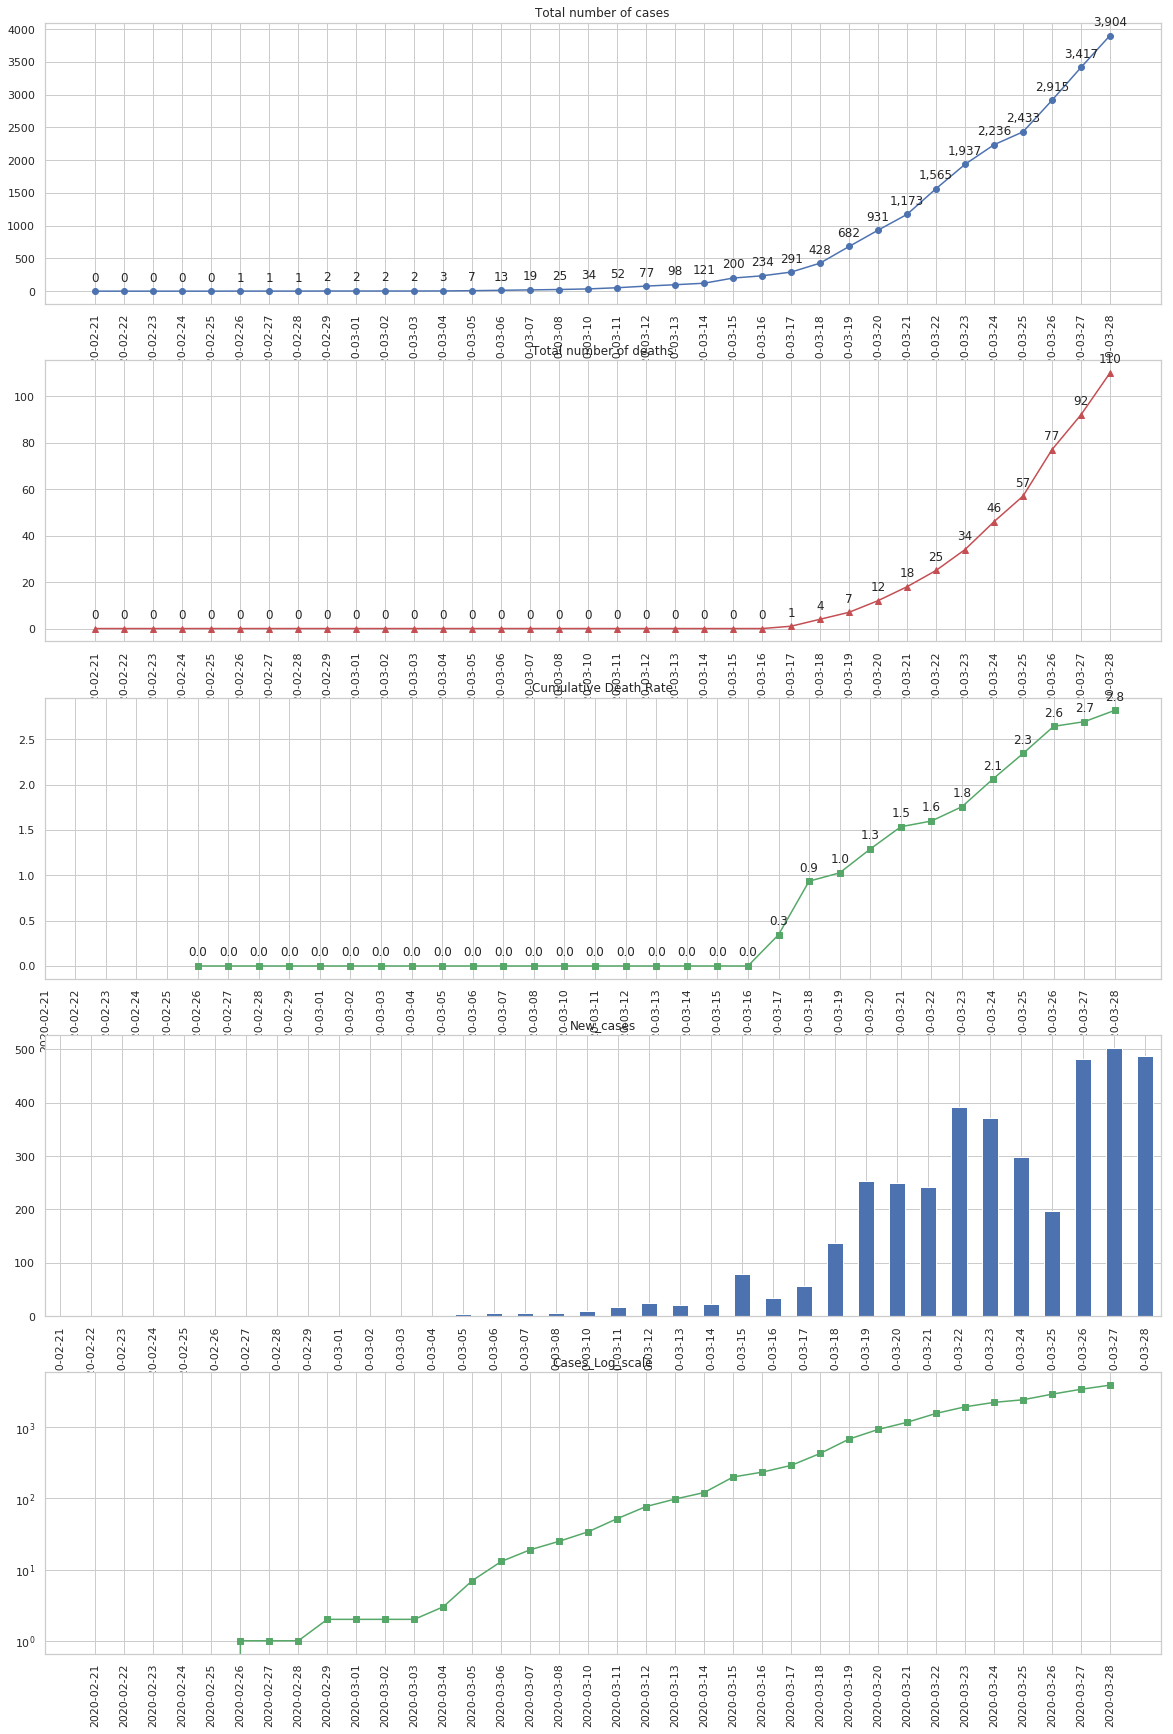

In [552]:
plt.figure(figsize = (20,30))

plt.subplot('511')
xs = br_date.index.values
ys = br_date['cases']
plt.gca().set_title('Total number of cases')
plt.plot(xs, ys, 'bo-')
plt.xticks(xs, xs, rotation='vertical')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('512')
plt.gca().set_title('Total number of deaths')
ys = br_date['deaths']
plt.plot(xs, ys, 'r^-')
plt.xticks(xs, xs, rotation='vertical')
for x,y in zip(xs,ys):
    label = "{:,.0f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.subplot('513')
plt.gca().set_title('Cumulative Death Rate')
ys = br_date['deaths'] / br_date['cases'] * 100
plt.plot(xs, ys, 'gs-')
plt.xticks(xs, xs, rotation='vertical')
for x,y in zip(xs,ys):
    label = "{:.1f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.subplot('514')
plt.gca().set_title('New_cases')
ys = br_date['new_cases']
# plt.plot(x = xs, y = ys)
br_date['new_cases'].plot(kind = 'bar')
# for x,y in zip(xs,ys):
#     label = "{:.0f}".format(y)
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center

# plt.savefig('./img/br_overview')

plt.subplot('515')
plt.gca().set_title('Cases_Log_scale')
ys =  br_date['cases']
plt.plot(xs, ys, 'gs-')
plt.yscale('log')
plt.xticks(xs, xs, rotation='vertical')
# for x,y in zip(xs,ys):
#     label = "{:.0f}".format(y)
#     plt.annotate(label, # this is the text
#                  (x,y), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,10), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center

plt.savefig('./img/br_overview')
plt.show()

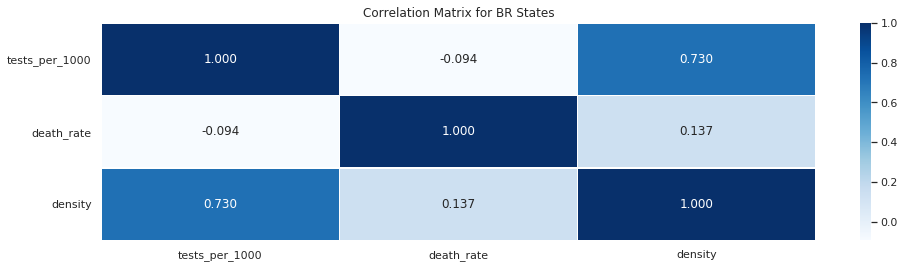

In [553]:
df_corr = br_state_data[['tests_per_1000','death_rate','density']].sort_values(by='tests_per_1000', ascending=False).corr()
plt.figure(figsize = (16,4))
title = 'Correlation Matrix for BR States'
# df_result = df_count.div(df_count.sum(axis = 0).sum(), axis = 1) * 100
plt.title(title)
sns.heatmap(df_corr, annot = True, linewidths = 0.5, cmap='Blues', fmt=',.3f')
plt.savefig('./img/' + title)

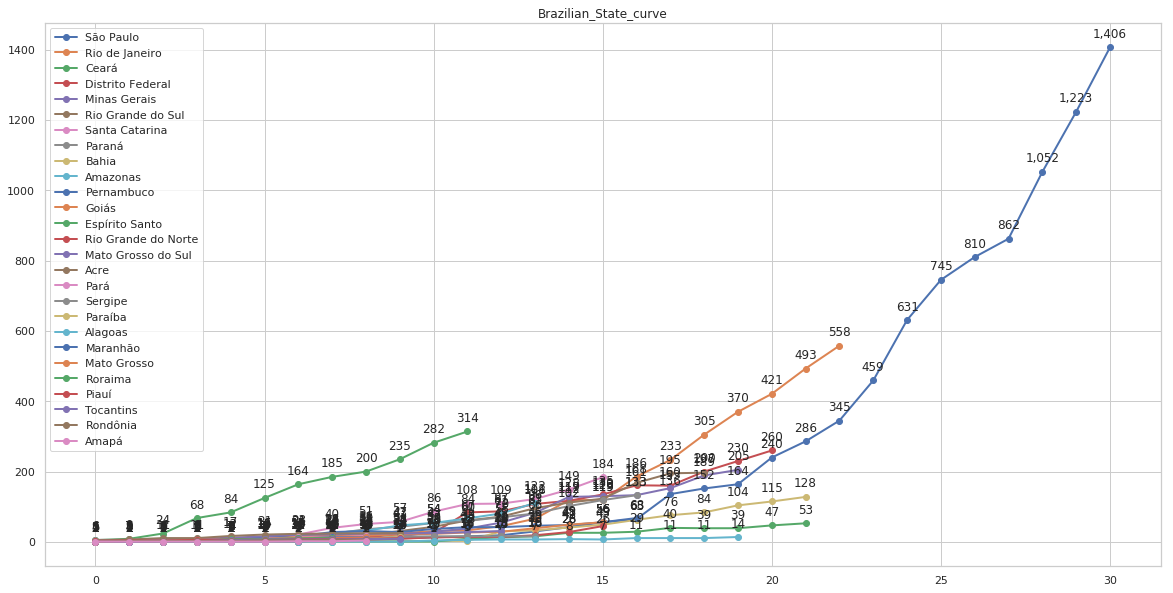

In [554]:
pt_br_state = br_state_copy.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state = pt_br_state.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

# plt.rc('font', **font)
title = 'Brazilian_State_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

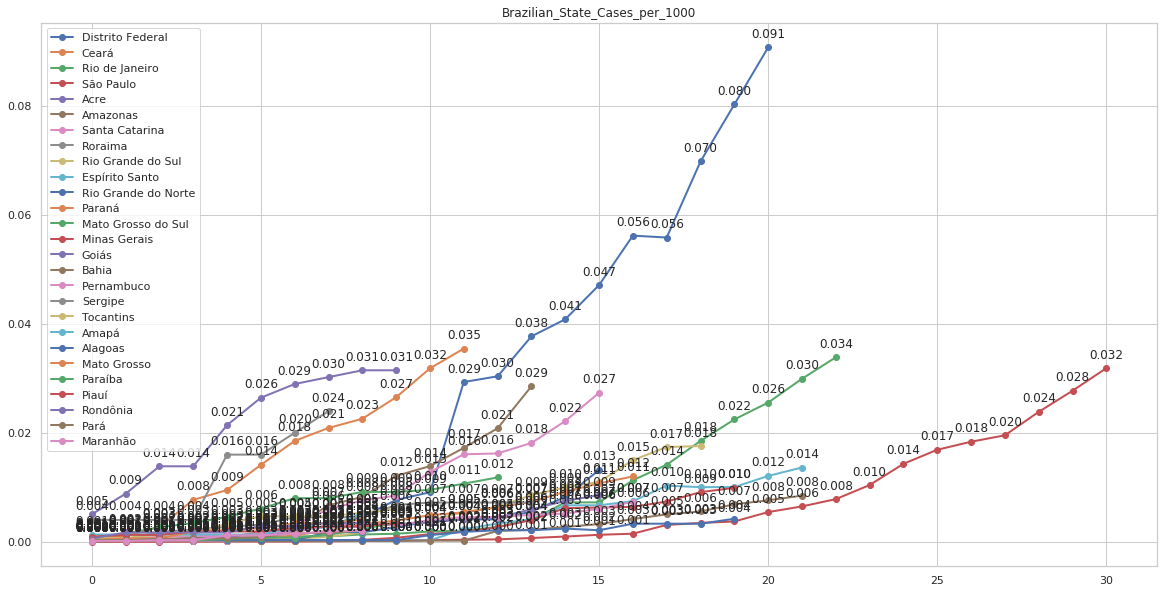

In [555]:
pt_br_state_adj =  pt_br_state.div(br_state_data['population'], axis = 0) * 1000
pt_br_state_adj = pt_br_state_adj.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_adj.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Brazilian_State_Cases_per_1000'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.3f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)

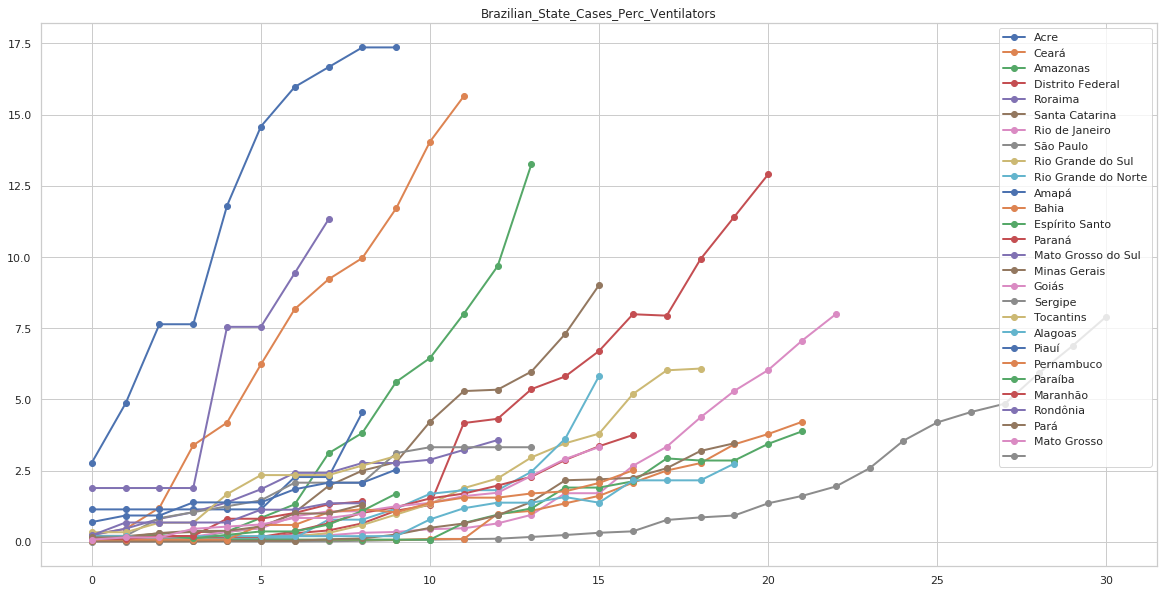

In [556]:
pt_br_state_adj =  pt_br_state.div(resp['equipments'], axis = 0) * 100
pt_br_state_adj = pt_br_state_adj.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_adj.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Brazilian_State_Cases_Perc_Ventilators'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

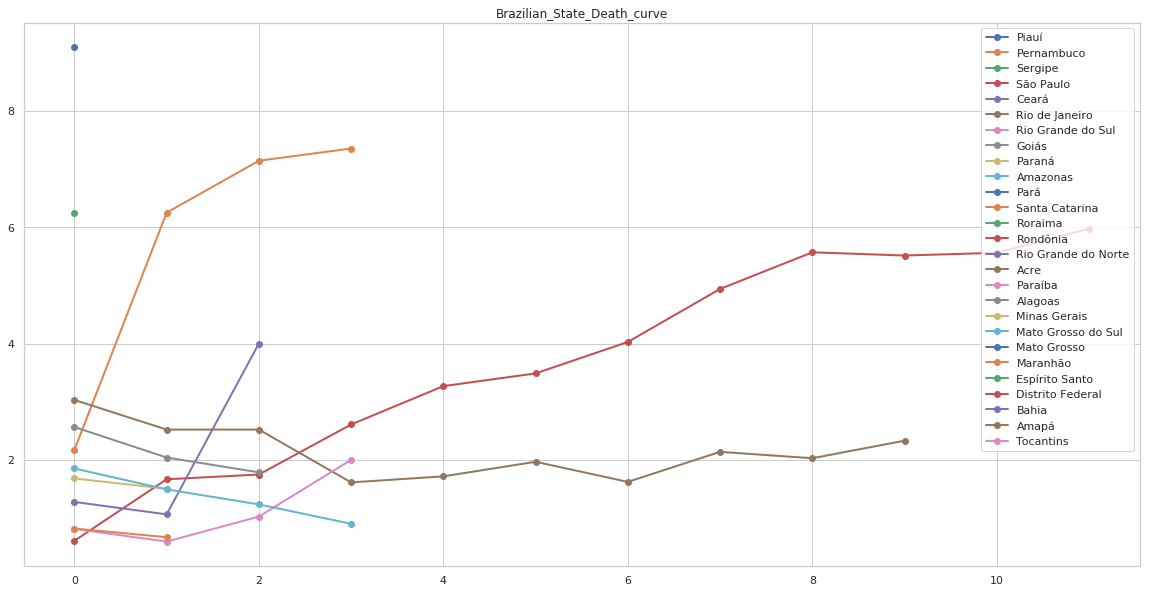

In [557]:
pt_br_state_death  = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc='sum') / pt_br_state * 100
pt_br_state_death.loc['Ceará']['2020-03-28'] = 4
pt_br_state_death.loc['Rio Grande do Sul']['2020-03-28'] = 2
pt_br_state_death = pt_br_state_death.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state_death.iterrows():
    temp = i[1]
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Brazilian_State_Death_curve'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

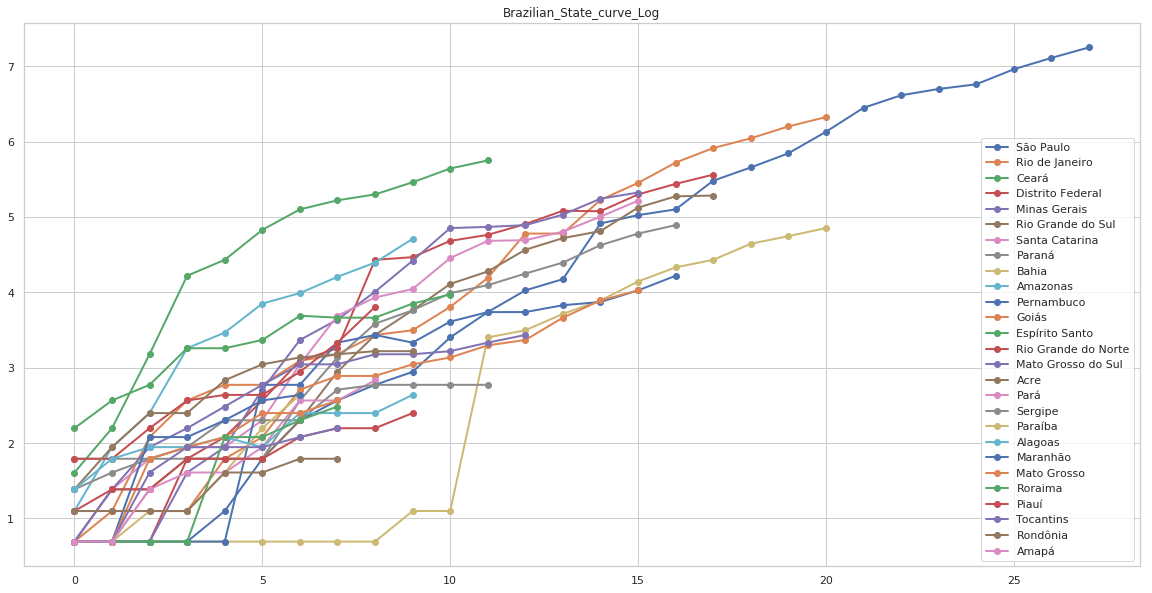

In [558]:
pt_br_state = br_state_copy.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc='sum')
pt_br_state = pt_br_state.sort_values(by=str_today, ascending = False)

df = pd.DataFrame()
for i in pt_br_state.iterrows():
    temp = i[1].apply(np.log)
    temp = temp.loc[temp > 0].reset_index(drop = True)
    df = df.append(temp)
    
df = df
    
plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Brazilian_State_curve_Log'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    plt.plot(temp.index, temp, label = i[1].name, linewidth=2, marker='o')
    plt.legend()
    
plt.savefig('./img/' + title)

In [559]:
br_cases = pd.DataFrame(br_state_copy.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc = 'sum').fillna(0).diff(axis = 1).fillna(0).unstack())
br_cases.columns = ['cases']
br_cases = br_cases.reset_index()

date,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,...,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28
state,,,,,,,,,,,,,,,,,,,,,
Acre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.177819,3.662161,5.419688,5.419688,7.285407,8.242034,8.572480,8.666931,8.703346,8.703346
Alagoas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.472304,3.461866,3.901248,3.901248,4.212201,3.973044,4.633934,4.633934,4.633934,4.647335
Amapá,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.494781,0.494781,0.494781,0.494781,0.494781,0.494781,0.589232,0.589232,0.598166
Amazonas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.783899,3.763022,5.520549,11.191123,13.056842,16.644194,17.800752,19.028622,19.538428,19.672434
Bahia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.044535,18.528878,22.043931,25.068237,29.421582,32.530620,33.852401,35.741432,36.141994,36.200063
Ceará,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.663932,35.434288,42.464395,57.963963,70.091138,75.113431,77.591769,80.897574,82.609065,82.752005
Distrito Federal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.831225,50.315567,59.542582,62.944927,68.542084,74.760161,74.594939,78.373001,79.465442,79.599449
Espírito Santo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.752234,9.236577,13.630393,13.630393,14.563253,17.193978,17.028755,17.028755,17.320073,17.346874
Goiás,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.117859,10.602201,10.602201,11.736316,12.358223,13.314850,13.645295,14.589811,14.953958,14.985226


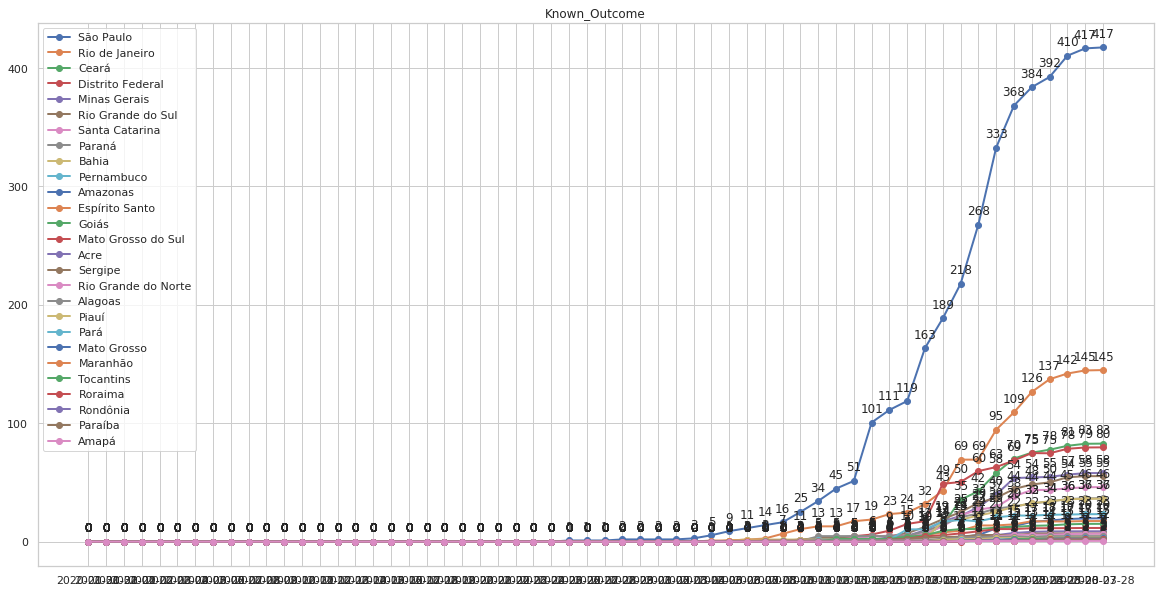

In [626]:
br_cases['rel_date'] = (dt.datetime.now() - pd.to_datetime(br_cases['date'])).dt.days
br_cases['known'] = HDT(br_cases['rel_date'])
br_cases['known_cases'] = br_cases['known'] * br_cases['cases']

br_total_cases = br_cases.pivot_table(values = 'cases', index = 'state', columns = 'date', aggfunc = 'sum').cumsum(axis = 1)
br_total_cases.loc['Brasil'] = br_total_cases.sum()
br_total_cases

br_known_cases = br_cases.pivot_table(values = 'known_cases', index = 'state', columns = 'date', aggfunc = 'sum').cumsum(axis = 1)
df = br_known_cases.sort_values(by=str_today, ascending = False)
br_known_cases.loc['Brasil'] = br_known_cases.sum()

plt.figure(figsize = (20,10))

plt.rc('font', **font)
title = 'Known_Outcome'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.0f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)
br_known_cases

In [528]:
br_deaths = br_state_copy.pivot_table(values = 'deaths', index = 'state', columns = 'date', aggfunc = 'sum').fillna(0)
br_deaths.loc['Ceará']['2020-03-28'] = 4
br_deaths.loc['Rio Grande do Sul']['2020-03-28'] = 2
br_deaths.loc['Brasil'] = br_deaths.sum()
br_deaths

date,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,...,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28
state,,,,,,,,,,,,,,,,,,,,,
Acre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alagoas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amapá,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Amazonas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
Bahia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ceará,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,4.0
Distrito Federal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Espírito Santo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Goiás,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [638]:
a = 114 / (899 / 0.102) 
b = (1090 / 0.110)
print(a)
print(a * b)
print(a * b / 0.029)

0.012934371523915461
128.16786328243504
4419.581492497759


In [639]:
a = 114 / (899 / 0.102) 
b = (1090 / 0.10)
print(a)
print(a * b)
print(a * b / 0.029)

0.012934371523915461
140.98464961067853
4861.539641747535


In [529]:
br_death_rate = (br_deaths / br_known_cases * 100).fillna(0)

In [530]:
br_death_rate = br_death_rate[br_death_rate[str_today] > 0]
br_death_rate

date,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,...,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28
state,,,,,,,,,,,,,,,,,,,,,
Amazonas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.061361,6.832950,6.803876,6.803876
Ceará,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.534312,4.519969,6.026625
Goiás,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.044375,8.015573,8.015573
Paraná,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.668365,6.668365
Pernambuco,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.942420,14.774082,19.664170,24.580212
Piauí,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36.088727
Rio Grande do Sul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.349658,2.262543,4.512772,4.512772
Rio de Janeiro,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.929548,4.697857,4.697857,3.542215,4.169571,5.564357,5.264612,7.770299,8.609758,11.192686
Sergipe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.769092


In [591]:
br_reported = (1.3 / br_death_rate * 100).replace(np.inf, np.nan)
br_reported = br_reported[br_reported.columns[-4:]].sort_values(by = str_today, ascending = False)

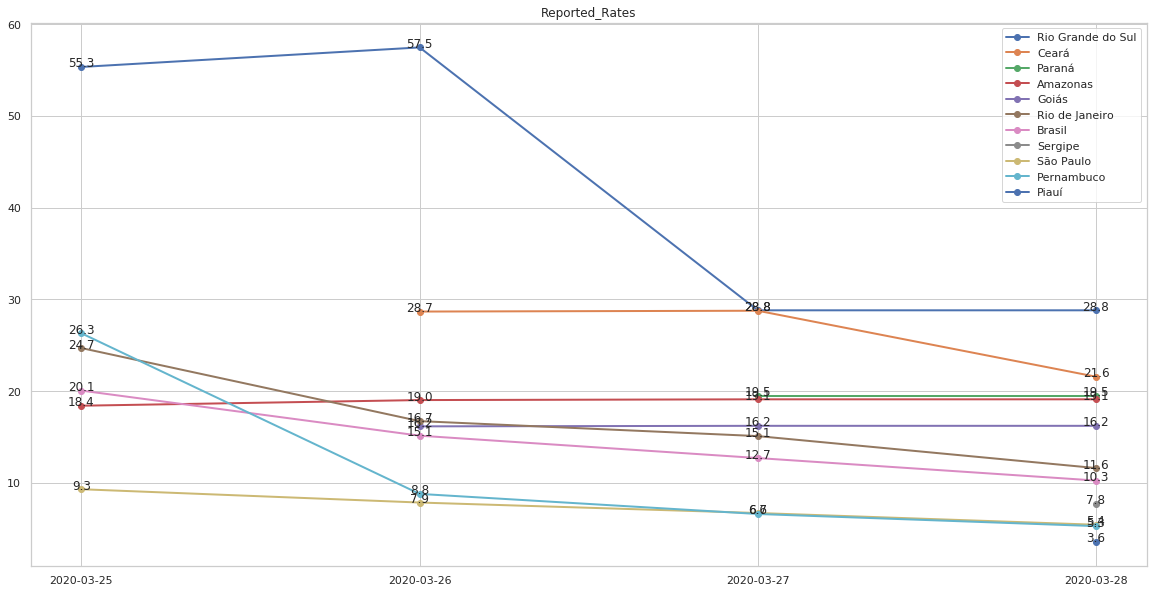

In [592]:
df = br_reported

plt.figure(figsize = (20,10))


plt.rc('font', **font)
title = 'Reported_Rates'
plt.title(title)
for i in df.T.iteritems():
    temp = i[1].dropna()
    xs = temp.index
    ys = temp
    plt.plot(xs, ys, label = i[1].name, linewidth=2, marker='o')
    for x,y in zip(xs,ys):
        label = "{:,.1f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    plt.legend()
    
plt.savefig('./img/' + title)